## Bipartite collaboration graph to simplicial complex and cochains


In this notebook we show how to build a collaboration complex (where each collaboration of authors is represented by a simplex) and citation cochains (which are the number of citations attributed to the collaborations). 

As point 3 of Section [Data], we will follow the following steps:

[Data]:https://github.com/stefaniaebli/simplicial_neural_networks#data

1) Downsample the bipartite graph to have a connected simplicial complex.

2) From a bipartite graph to a simplicial complex with k-cochains.

3) From a simplicial complex to k-degree Laplacians.

4) Artificially insert missing data on k-cochains.


In [1]:
import numpy as np
import scipy
from scipy import sparse
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.append('..')
from data.s2_4_bipartite_to_downsampled import subsample_node_x,starting_node_random_walk
from data.s2_5_bipartite_to_complex import bipart2simpcochain
from data.s2_6_complex_to_laplacians import build_boundaries, build_laplacians
from data.s2_7_cochains_to_missingdata import build_missing_values, build_damaged_dataset,built_known_values
%matplotlib inline

### 1) Downsample the bipartite graph to have a connected simplicial complex.

First we load the bipartite graph from the Semantic Scholar dataset together with the citations of the articles. Then we will downasample the set of papers to obtain a connected simplicial complex,

In [2]:
adjacency_papers = sparse.load_npz('../data/s2_2_bipartite_graph/papers_adjacency.npz')
adjacency = scipy.sparse.load_npz('../data/s2_2_bipartite_graph/paper_author_biadjacency.npz')
papers = pd.read_csv('../data/s2_2_bipartite_graph/papers.csv', index_col=0)
citations=np.array(papers['citations_2019'])

In [3]:
starting_node=starting_node_random_walk(adjacency,weights_x=citations, min_weight=100, max_dim=10 )
print("The starting node of the random walk has ID {}".format(starting_node))
downsample= subsample_node_x(adjacency_papers,adjacency,weights_x=citations, min_weight=5, max_dim=10,length_walk=80)
print("The number of downsampled papers is {}".format(len(downsample)))
#np.save('../data/s2_3_collaboration_complex/'+str(starting_node)+'_downsampled.npy',downsample

The starting node of the random walk has ID 134702
The number of downsampled papers is 109


### 2) From a bipartite graph to a simplicial complex with k-cochains.

In [4]:
##load downsampling
s_node=150250 ###starting node of the random walk

output=str(s_node)
downsample_papers=np.load('../data/s2_3_collaboration_complex/'+str(s_node)+'_downsampled.npy')

simplices, cochains, signals_top = bipart2simpcochain(adjacency, citations, indices_x=downsample_papers, dimension=10)
#np.save('../data/s2_3_collaboration_complex/'+output+'_cochains.npy',cochains)
#np.save('../data/s2_3_collaboration_complex/'+output+'_simplices.npy',simplices)



Printing the number of simplices of the simplicial complex

In [5]:
for k, simp in enumerate(simplices):
    print('The number of {}-simplices is {:,}'.format(k, len(simp)))

The number of 0-simplices is 352
The number of 1-simplices is 1,474
The number of 2-simplices is 3,285
The number of 3-simplices is 5,019
The number of 4-simplices is 5,559
The number of 5-simplices is 4,547
The number of 6-simplices is 2,732
The number of 7-simplices is 1,175
The number of 8-simplices is 343
The number of 9-simplices is 61
The number of 10-simplices is 5


Plotting the distribution of the values of the cochains in dimension $1$, $2$ and $3$.

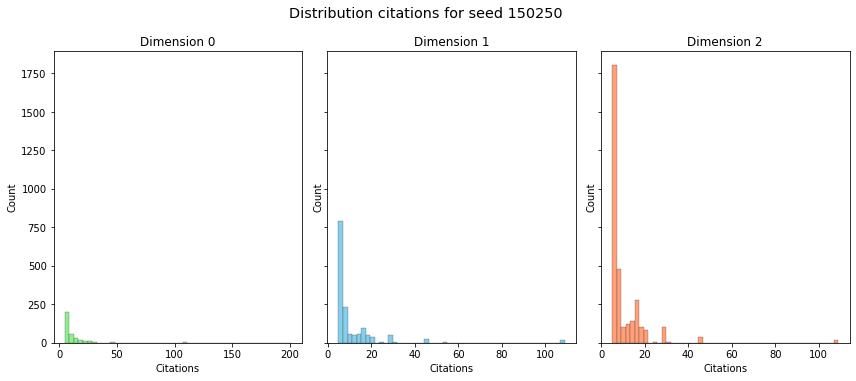

In [6]:
target_cochain=np.load('../data/s2_3_collaboration_complex/'+output+'_cochains.npy',allow_pickle=True)
target_cochain_0=np.array(list(target_cochain[0].values()))  
target_cochain_1=np.array(list(target_cochain[1].values()))  
target_cochain_2=np.array(list(target_cochain[2].values()))     
n_bins = 50

#plt.figure(figsize=(8,4))
fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True,figsize=(12,5))

axs[0].hist(target_cochain_0, bins=n_bins,color = "lightgreen", ec='black',lw=0.2)
axs[0].set_xlabel("Citations")
axs[0].set_ylabel("Count")
axs[0].set_title('Dimension 0')
axs[1].hist(target_cochain_1, bins=n_bins,color = "skyblue", ec='black',lw=0.2)
axs[1].set_title('Dimension 1')
axs[1].set_xlabel("Citations")
axs[1].set_ylabel("Count")
axs[2].hist(target_cochain_2, bins=n_bins,color = "lightsalmon", ec='black',lw=0.2)
axs[2].set_title('Dimension 2')
axs[2].set_xlabel("Citations")
axs[2].set_ylabel("Count")
fig.suptitle('Distribution citations for seed {} '.format(s_node), y=1.05,fontsize="x-large");
#plt.savefig('distribution_cochains_{}.png'.format(s_node))

### 3) From a simplicial complex to k-degree Laplacians.

In [7]:
simplices=np.load(f'../data/s2_3_collaboration_complex/{s_node}_simplices.npy',allow_pickle=True)

boundaries=build_boundaries(simplices)
laplacians=build_laplacians(boundaries)
#np.save(f'../data/s2_3_collaboration_complex/{s_node}_laplacians.npy', laplacians)
#np.save(f'../data/s2_3_collaboration_complex/{s_node}_boundaries.npy', boundaries)


Plot density Laplacians

In [8]:
laplacians = np.load(f'../data/s2_3_collaboration_complex/{s_node}_laplacians.npy',allow_pickle=True)

for k, laplacian in enumerate(laplacians):
    print('{}-simplices: {:,} simplices, {:.5%} dense'.format(k, laplacian.shape[0], laplacian.nnz/np.prod(laplacian.shape)))
    assert laplacian.shape == (len(simplices[k]), len(simplices[k]))

0-simplices: 352 simplices, 2.66335% dense
1-simplices: 1,474 simplices, 1.17210% dense
2-simplices: 3,285 simplices, 0.04353% dense
3-simplices: 5,019 simplices, 0.02151% dense
4-simplices: 5,559 simplices, 0.01812% dense
5-simplices: 4,547 simplices, 0.02199% dense
6-simplices: 2,732 simplices, 0.03660% dense
7-simplices: 1,175 simplices, 0.08511% dense
8-simplices: 343 simplices, 0.29155% dense
9-simplices: 61 simplices, 1.63934% dense
10-simplices: 5 simplices, 20.00000% dense


### 4) Artificially insert missing data on k-cochains.

In [9]:
percentage_missing_data=[10,20,30,40,50]
for percentage in percentage_missing_data:

    output=str(s_node)+'_percentage_'+str(percentage)
   
    missing_values=build_missing_values(simplices,percentage_missing_values=percentage,max_dim=10)
    damaged_dataset=build_damaged_dataset(cochains,missing_values,function=np.median)
    known_values=built_known_values(missing_values,simplices)
    #np.save(f'../data/s2_3_collaboration_complex/{s_node}_percentage_{percentage}_missing_values.npy', missing_values)
    #np.save(f'../data/s2_3_collaboration_complex/{s_node}_percentage_{percentage}_input_damaged.npy', damaged_dataset)
    #np.save(f'../data/s2_3_collaboration_complex/{s_node}_percentage_{percentage}_known_values.npy', known_values)

 Plot distribution misisng citations  and known citations in dimension $0$, $1$ and $2$

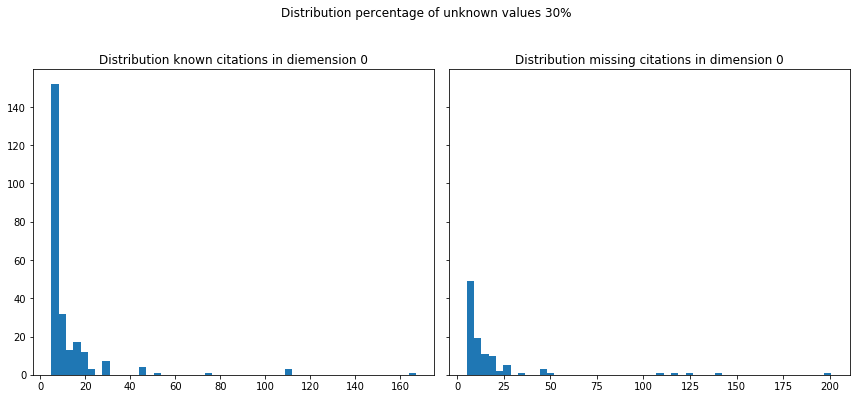

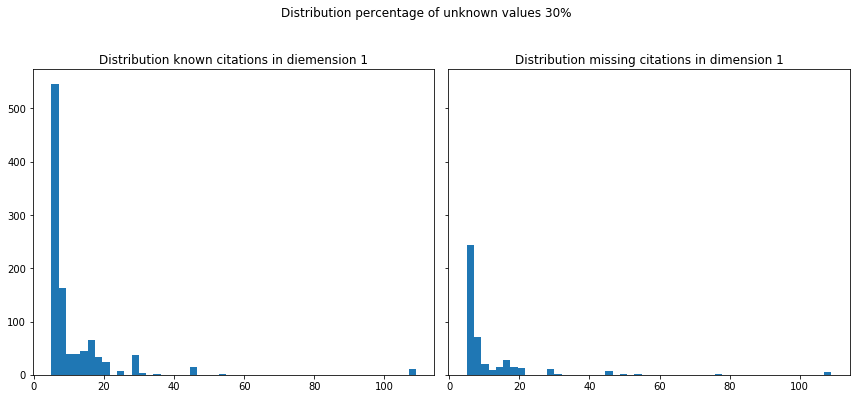

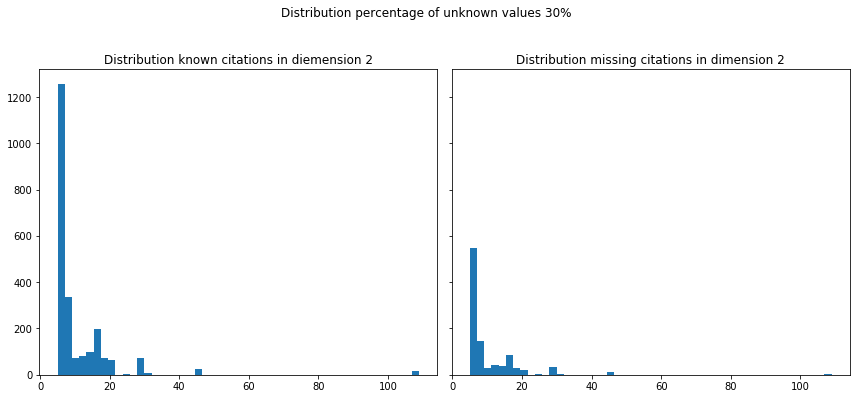

In [10]:
for percentage in [30]:
    for dim in range(0,3):
        
        output=str(s_node)
        target_cochain=np.load('../data/s2_3_collaboration_complex/'+output+'_cochains.npy',allow_pickle=True)
        target_cochain=np.array(list(target_cochain[dim].values()))
        mask_seen=np.load(f'../data/s2_3_collaboration_complex/{s_node}_percentage_{percentage}_known_values.npy',allow_pickle=True)
        mask_seen=list(mask_seen[dim].values())
        mask_unseen=np.load(f'../data/s2_3_collaboration_complex/{s_node}_percentage_{percentage}_missing_values.npy',allow_pickle=True)
        mask_unseen=list(mask_unseen[dim].values())

        n_bins = 50
        # Generate a normal distribution, center at x=0 and y=5
        x=target_cochain[mask_seen]
        y = target_cochain[mask_unseen]

        #plt.figure(figsize=(8,4))
        fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True,figsize=(12,5))

        # We can set the number of bins with the `bins` kwarg
        axs[0].hist(x, bins=n_bins)
        axs[0].set_title('Distribution known citations in diemension {}'.format(dim))
        axs[1].hist(y, bins=n_bins)
        plt.title('Distribution missing citations in dimension {}'.format(dim))
        fig.suptitle("Distribution percentage of unknown values {0}% ".format(percentage),y=1.1)
        plt.show()